In [1]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.optimize import linear_sum_assignment
import os
import nibabel as nib
from dipy.io.streamline import load_tractogram, save_tck
import time

In [2]:
reference_anatomy = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedpost\fa.nii.gz'
reference_anatomy1 = nib.load(reference_anatomy)
tck1 = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedpost\CST_left_aligned2.tck'
tck2 = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedpre\CST_left_aligned2.tck'
tckr1 = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedpost\CST_right_aligned2.tck'
tckr2 = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedpre\CST_right_aligned2.tck'
tractogram1 = load_tractogram(tck1, reference_anatomy1)
tractogram2 = load_tractogram(tck2, reference_anatomy1)
tractogramr1= load_tractogram(tckr1, reference_anatomy1)
tractogramr2= load_tractogram(tckr2, reference_anatomy1)
streamlines1 = tractogram1.streamlines
streamlines2 = tractogram2.streamlines
streamlinesr1 = tractogramr1.streamlines
streamlinesr2 = tractogramr2.streamlines

In [3]:
def compute_centroid(streamline):
    """Compute the centroid of a streamline."""
    return np.mean(streamline, axis=0)

def centroid_distance(u_centroid, v_centroid):
    """Compute the Euclidean distance between two centroids."""
    return np.linalg.norm(u_centroid - v_centroid)

In [4]:
def hausdorff_distance(u, v):

    return min(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

In [5]:
def distance_matrix_hausdorff(bundle1, bundle2):
    """
    Compute a distance matrix using Hausdorff distances between streamlines in bundle1 and bundle2.
    """
    distance_matrix = np.zeros((len(bundle1), len(bundle2)))
    
    for i, u in enumerate(bundle1):
        for j, v in enumerate(bundle2):
            distance_matrix[i, j] = hausdorff_distance(u, v)
    
    return distance_matrix

In [28]:
def one_to_one_map_streamlines(bundle1, bundle2):
    start_time = time.time()
    
    # Compute the distance matrix
    distance_matrix = distance_matrix_hausdorff(bundle1, bundle2)
    print('distance matrix complete')
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time for hausdorf: {execution_time} seconds")
    start_time = time.time()

    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    print('Hungarian complete')
    
    end_time = time.time()

    # Calculate and print execution time
    execution_time = end_time - start_time
    print(f"Execution time for hungarian: {execution_time} seconds")
    
    # Create a mapping from indices in bundle1 to indices in bundle2
    return dict(zip(row_ind, col_ind))

In [7]:
def one_to_one_map_streamlines_old(bundle1, bundle2):
    start_time = time.time()
    """Maps streamlines using centroid-based distances."""
    # Compute centroids for each streamline
    centroids1 = np.array([compute_centroid(s) for s in bundle1])
    print('centroids1 complete')
    centroids2 = np.array([compute_centroid(s) for s in bundle2])
    print('centroids2 complete')
    # Initialize a matrix to hold distances between centroids
    distance_matrix = np.zeros((len(centroids1), len(centroids2)))

    # Populate the distance matrix with Euclidean distances between centroids
    distance_matrix = vectorized_distance_matrix(centroids1, centroids2)
    print('distance matrix complete')
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    print('hungarian complete')
    end_time = time.time()  # Capture end time

    # Calculate and print the execution time
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")
    # Create a mapping from indices in bundle1 to indices in bundle2
    return dict(zip(row_ind, col_ind))

In [11]:
#mapping1 = one_to_one_map_streamlines(streamlines2[:100], streamlines1[:100])

In [8]:
def compute_segment_distances(streamline1, streamline2):
    """
    Compute distances between corresponding segments of two matched streamlines.
    Assumes streamline1 and streamline2 have the same number of segments.
    """
    # Calculate distances between corresponding points
    distances = np.linalg.norm(streamline1 - streamline2, axis=1)
    return distances

def compute_min_segment_distances(streamline1, streamline2):
    """
    Compute minimum segment distances between two streamlines considering
    both direct and inverted orders of the second streamline.
    """
    direct_distances = compute_segment_distances(streamline1, streamline2)
    inverted_distances = compute_segment_distances(streamline1, streamline2[::-1])
    return np.minimum(direct_distances, inverted_distances)

In [9]:
def segment_distances_for_mapping_old(bundle1, bundle2, mapping):
    """
    Computes minimum segment distances for all matched streamline pairs according to the provided mapping.
    Takes into account the potential inversion of one streamline.
    Returns a list of arrays, where each array contains the minimum distances for one matched pair.
    """
    segment_distances = []
    for i, j in mapping.items():
        distances = compute_min_segment_distances(bundle1[i], bundle2[j])
        segment_distances.append(distances)
    return segment_distances

In [10]:
def compute_minimum_distances(streamline1, streamline2):
    """
    Compute minimum distances from each point in streamline1 to the closest point in streamline2 and vice versa.
    Returns two arrays: distances from streamline1 to streamline2, and from streamline2 to streamline1.
    """
    # Create a distance matrix from every point in streamline1 to every point in streamline2
    distance_matrix = np.linalg.norm(streamline1[:, np.newaxis] - streamline2, axis=2)

    # Find the minimum distance for each point in streamline1 to streamline2
    distances1_2 = np.min(distance_matrix, axis=1)

    # Find the minimum distance for each point in streamline2 to streamline1
    distances2_1 = np.min(distance_matrix, axis=0)

    return distances1_2, distances2_1

In [11]:
def segment_distances_for_mapping(bundle1, bundle2, mapping):
    """
    Computes minimum segment distances for all matched streamline pairs according to the provided mapping.
    Returns two lists of arrays: one for distances from bundle1 to bundle2 and one for distances from bundle2 to bundle1.
    """
    distances1_2 = []
    distances2_1 = []
    for i, j in mapping.items():
        min_distances_1_to_2, min_distances_2_to_1 = compute_minimum_distances(bundle1[i], bundle2[j])
        distances1_2.append(min_distances_1_to_2)
        distances2_1.append(min_distances_2_to_1)
    return distances1_2, distances2_1

In [12]:
def compute_cost_matrix(directions1, directions2):
    cost_matrix = np.zeros((len(directions1), len(directions2)))
    for i, dir1 in enumerate(directions1):
        for j, dir2 in enumerate(directions2):
            cost_matrix[i, j] = np.linalg.norm(dir1 - dir2)
    return cost_matrix

In [13]:
def calculate_direction_vectors(streamline):
    # Subtract each point from the next to get the direction vectors
    return np.diff(streamline, axis=0)

In [14]:
def calculate_vector_difference(v1, v2):
    # Normalize vectors
    norm_v1 = v1 / np.linalg.norm(v1)
    norm_v2 = v2 / np.linalg.norm(v2)
    # Calculate angle using dot product
    cosine_angle = np.clip(np.dot(norm_v1, norm_v2), -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    # Scale angle to [0, 1] where 0 is same direction and 1 is opposite
    return angle / np.pi

In [15]:
def compute_differences_with_closest_segments(streamlines1, streamlines2, mapping):
    differences_bundle1 = []
    differences_bundle2 = []

    for idx1, idx2 in mapping.items():
        s1 = streamlines1[idx1]
        s2 = streamlines2[idx2]

        directions1 = calculate_direction_vectors(s1)
        directions2 = calculate_direction_vectors(s2)

        midpoints1 = (s1[:-1] + s1[1:]) / 2
        midpoints2 = (s2[:-1] + s2[1:]) / 2
        distance_matrix = np.linalg.norm(midpoints1[:, np.newaxis, :] - midpoints2[np.newaxis, :, :], axis=2)

        differences1 = []
        for i in range(len(directions1)):
            j = np.argmin(distance_matrix[i])
            difference = calculate_vector_difference(directions1[i], directions2[j])
            differences1.append(difference)
        differences_bundle1.append(differences1)

        differences2 = []
        for j in range(len(directions2)):
            i = np.argmin(distance_matrix[:, j])
            difference = calculate_vector_difference(directions2[j], directions1[i])
            differences2.append(difference)
        differences_bundle2.append(differences2)

    return differences_bundle1, differences_bundle2

In [16]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def compute_differences_with_bipartite_matching(streamlines1, streamlines2, mapping):
    differences_bundle1 = []
    differences_bundle2 = []
    
    for pair in mapping:
        idx1, idx2 = pair
        s1 = streamlines1[idx1]
        s2 = streamlines2[idx2]
        
        # Calculate direction vectors in normal and inverted orders
        directions1 = calculate_direction_vectors(s1)
        directions2 = calculate_direction_vectors(s2)
        directions2_inverted = calculate_direction_vectors(s2[::-1])  # Invert the streamline order
        
        # Compute cost matrices for both normal and inverted directions
        cost_matrix_normal = compute_cost_matrix(directions1, directions2)
        cost_matrix_inverted = compute_cost_matrix(directions1, directions2_inverted)
        
        # Apply the Hungarian algorithm to both cost matrices
        row_ind_normal, col_ind_normal = linear_sum_assignment(cost_matrix_normal)
        row_ind_inverted, col_ind_inverted = linear_sum_assignment(cost_matrix_inverted)
        
        # Calculate the total costs for both matchings
        total_cost_normal = cost_matrix_normal[row_ind_normal, col_ind_normal].sum()
        total_cost_inverted = cost_matrix_inverted[row_ind_inverted, col_ind_inverted].sum()
        
        # Determine which matching to use based on the lower total cost for each pair
        if total_cost_normal <= total_cost_inverted:
            row_ind, col_ind = row_ind_normal, col_ind_normal
            cost_matrix = cost_matrix_normal
            directions2_used = directions2
        else:
            row_ind, col_ind = row_ind_inverted, col_ind_inverted
            cost_matrix = cost_matrix_inverted
            directions2_used = directions2_inverted
        
        # Calculate differences for bundle1
        differences1 = []
        for i in range(len(directions1)):
            if i in row_ind:
                matched_index = col_ind[np.where(row_ind == i)[0][0]]
                differences1.append(calculate_vector_difference(directions1[i], directions2_used[matched_index]))
            else:
                differences1.append(1)  # Max difference when no match found
        
        # Calculate differences for bundle2
        differences2 = []
        for j in range(len(directions2_used)):
            if j in col_ind:
                matched_index = row_ind[np.where(col_ind == j)[0][0]]
                differences2.append(calculate_vector_difference(directions2_used[j], directions1[matched_index]))
            else:
                differences2.append(1)  # Max difference when no match found
        
        differences_bundle1.append(differences1)
        differences_bundle2.append(differences2)
    
    return differences_bundle1, differences_bundle2

In [17]:
def compute_differences_with_closest_points(streamlines1, streamlines2, mapping):
    differences_bundle1 = []
    differences_bundle2 = []

    for idx1, idx2 in mapping.items():
        s1 = streamlines1[idx1]
        s2 = streamlines2[idx2]

        # Ensure streamlines have enough points
        if len(s1) < 2 or len(s2) < 2:
            # Assign zero differences if tangent vectors cannot be computed
            differences1 = [0.0] * len(s1)
            differences2 = [0.0] * len(s2)
            differences_bundle1.append(differences1)
            differences_bundle2.append(differences2)
            continue

        # Calculate tangent vectors at each point
        tangents1 = calculate_tangent_vectors(s1)
        tangents2 = calculate_tangent_vectors(s2)

        # Compute distance matrix between points
        distance_matrix = np.linalg.norm(s1[:, np.newaxis, :] - s2[np.newaxis, :, :], axis=2)

        # For each point in s1, find the closest point in s2
        differences1 = []
        for i in range(len(s1)):
            j = np.argmin(distance_matrix[i])
            difference = calculate_vector_difference(tangents1[i], tangents2[j])
            differences1.append(difference)
        differences_bundle1.append(differences1)

        # For each point in s2, find the closest point in s1
        differences2 = []
        for j in range(len(s2)):
            i = np.argmin(distance_matrix[:, j])
            difference = calculate_vector_difference(tangents2[j], tangents1[i])
            differences2.append(difference)
        differences_bundle2.append(differences2)

    return differences_bundle1, differences_bundle2

def calculate_tangent_vectors(streamline):
    # Initialize tangent vectors
    tangents = np.zeros_like(streamline)

    # Handle streamlines with less than two points
    if len(streamline) < 2:
        return tangents

    # Use central differences for internal points
    tangents[1:-1] = streamline[2:] - streamline[:-2]

    # Forward difference for the first point
    tangents[0] = streamline[1] - streamline[0]

    # Backward difference for the last point
    tangents[-1] = streamline[-1] - streamline[-2]

    # Normalize the tangents
    norms = np.linalg.norm(tangents, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1
    tangents = tangents / norms

    return tangents

In [18]:
from dipy.align.streamlinear import StreamlineLinearRegistration
import glob
import json

In [24]:
tck_directory2 = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2'
tck_directory1 = r'C:\Users\tudor\Desktop\thesis\prepost\preop'
reference_anatomy_path1 = r'C:\Users\tudor\Desktop\thesis\prepost\preop\fa.nii.gz'
reference_anatomy1 = nib.load(reference_anatomy_path1)
output_directory = r'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays'

# List and sort all .tck files in the directory
tck_files1 = sorted(glob.glob(os.path.join(tck_directory1, '*.tck')))
tck_files2 = sorted(glob.glob(os.path.join(tck_directory2, '*.tck')))
tck_files_iterator = iter(tck_files2)

In [30]:
def get_base_name(filename):
    basename = os.path.basename(filename)
    basename = os.path.splitext(basename)[0]
    basename = basename.replace('_aligned', '').replace('_aligned2', '')
    return basename


In [31]:
preop_files = glob.glob(os.path.join(tck_directory1, '*.tck'))
postop_files = glob.glob(os.path.join(tck_directory2, '*.tck'))
# Create dictionaries mapping base names to file paths
preop_dict = {get_base_name(f): f for f in preop_files}
postop_dict = {get_base_name(f): f for f in postop_files}

# Find common base names
common_basenames = set(preop_dict.keys()) & set(postop_dict.keys())

print(f"Found {len(common_basenames)} matching bundles.")


Found 70 matching bundles.


In [ ]:
for basename in common_basenames:
    try:
        preop_path = preop_dict[basename]
        postop_path = postop_dict[basename]

        # Load tractograms
        tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
        tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

        streamlines_preop = tractogram_preop.streamlines
        streamlines_postop = tractogram_postop.streamlines

        # Limit to 3000 streamlines if necessary
        num_streamlines = min(3000, len(streamlines_preop), len(streamlines_postop))
        streamlines_preop = streamlines_preop[:num_streamlines]
        streamlines_postop = streamlines_postop[:num_streamlines]

        # Compute the mapping
        mapping = one_to_one_map_streamlines(streamlines_preop, streamlines_postop)
        mapping_list = [[int(key), int(value)] for key, value in mapping.items()]

        # Transpose mapping_list
        mapping_listl = list(zip(*mapping_list))
        mapping_listl = [list(mapping_listl[0]), list(mapping_listl[1])]

        # Compute distances
        x, y = segment_distances_for_mapping(streamlines_preop, streamlines_postop, mapping)
        differences_bundle1, differences_bundle2 = compute_differences_with_closest_segments(streamlines_preop, streamlines_postop, mapping)

        # Prepare data for saving
        distances = [[distance.tolist() for distance in x], [distance.tolist() for distance in y]]
        color = [differences_bundle1, differences_bundle2]

        # Create output directory for the bundle
        bundle_output_dir = os.path.join(output_directory, basename)
        os.makedirs(bundle_output_dir, exist_ok=True)

        # Save mapping
        mapping_path = os.path.join(bundle_output_dir, 'mapping.json')
        with open(mapping_path, 'w') as file:
            json.dump(mapping_listl, file)

        # Save distances
        distances_path = os.path.join(bundle_output_dir, 'distances.json')
        with open(distances_path, 'w') as file:
            json.dump(distances, file)

        # Save color differences
        color_path = os.path.join(bundle_output_dir, 'color.json')
        with open(color_path, 'w') as file:
            json.dump(color, file)

        print(f"Processed bundle: {basename}")

    except Exception as e:
        print(f"Error processing bundle {basename}: {e}")

distance matrix complete
Hungarian complete
Execution time: 2374.3257913589478 seconds
Processed bundle: ST_PREF_left
distance matrix complete
Hungarian complete
Execution time: 2667.5298750400543 seconds
Processed bundle: MCP
distance matrix complete
Hungarian complete
Execution time: 2393.926548719406 seconds
Processed bundle: SCP_right
distance matrix complete
Hungarian complete
Execution time: 2392.6597952842712 seconds
Processed bundle: SCP_left
distance matrix complete
Hungarian complete
Execution time: 2492.3616094589233 seconds
Processed bundle: ILF_right


In [52]:
preop_path = r'C:\Users\tudor\Desktop\thesis\prepost\preop\IFO_right.tck'
postop_path = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2\IFO_right_aligned.tck'

basename = 'IFO'

# Load tractograms
tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

streamlines_preop = tractogram_preop.streamlines
streamlines_postop = tractogram_postop.streamlines

# Limit to 3000 streamlines if necessary
num_streamlines = min(3000, len(streamlines_preop), len(streamlines_postop))
streamlines_preop = streamlines_preop[:num_streamlines]
streamlines_postop = streamlines_postop[:num_streamlines]

# Compute the mapping
mapping = one_to_one_map_streamlines(streamlines_postop, streamlines_preop)
mapping_list = [[int(key), int(value)] for key, value in mapping.items()]

# Transpose mapping_list
mapping_listl = list(zip(*mapping_list))
mapping_listl = [list(mapping_listl[0]), list(mapping_listl[1])]

start_time = time.time()
# Compute distances
x, y = segment_distances_for_mapping(streamlines_preop, streamlines_postop, mapping)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for distances: {execution_time} seconds")


start_time = time.time()
differences_bundle1, differences_bundle2 = compute_differences_with_closest_segments(streamlines_preop, streamlines_postop, mapping)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for coloring: {execution_time} seconds")

# Prepare data for saving
distances = [[distance.tolist() for distance in x], [distance.tolist() for distance in y]]
color = [differences_bundle1, differences_bundle2]

# Create output directory for the bundle
bundle_output_dir = os.path.join(output_directory, basename)
os.makedirs(bundle_output_dir, exist_ok=True)

# Save mapping
mapping_path = os.path.join(bundle_output_dir, 'mapping_right.json')
with open(mapping_path, 'w') as file:
    json.dump(mapping_listl, file)

# Save distances
distances_path = os.path.join(bundle_output_dir, 'distances_right.json')
with open(distances_path, 'w') as file:
    json.dump(distances, file)

# Save color differences
color_path = os.path.join(bundle_output_dir, 'color_right.json')
with open(color_path, 'w') as file:
    json.dump(color, file)

print(f"Processed bundle: {basename}")

distance matrix complete
Hungarian complete
Execution time: 3058.223073720932 seconds
Execution time for distances: 0.17099952697753906 seconds
Execution time for coloring: 6.081456661224365 seconds
Processed bundle: IFO


In [27]:
preop_path = r'C:\Users\tudor\Desktop\thesis\prepost\preop\IFO_left.tck'
postop_path = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2\IFO_left_aligned.tck'

basename = 'IFO'
tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

streamlines_preop = tractogram_preop.streamlines
streamlines_postop = tractogram_postop.streamlines

num_streamlines = min(3000, len(streamlines_preop), len(streamlines_postop))
streamlines_preop = streamlines_preop[:num_streamlines]
streamlines_postop = streamlines_postop[:num_streamlines]

mapping = one_to_one_map_streamlines(streamlines_postop, streamlines_preop)
mapping_list = [[int(key), int(value)] for key, value in mapping.items()]

mapping_listl = list(zip(*mapping_list))
mapping_listl = [list(mapping_listl[0]), list(mapping_listl[1])]

start_time = time.time()
x, y = segment_distances_for_mapping(streamlines_preop, streamlines_postop, mapping)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for distances: {execution_time} seconds")

start_time = time.time()
differences_bundle1, differences_bundle2 = compute_differences_with_closest_segments(streamlines_preop, streamlines_postop, mapping)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time for coloring: {execution_time} seconds")

distances = [[distance.tolist() for distance in x], [distance.tolist() for distance in y]]
color = [[distance for distance in differences_bundle1], [distance for distance in differences_bundle2]]

bundle_output_dir = os.path.join(output_directory, basename)
os.makedirs(bundle_output_dir, exist_ok=True)

#save mapping
mapping_path = os.path.join(bundle_output_dir, 'mapping_left.json')
with open(mapping_path, 'w') as file:
    json.dump(mapping_listl, file)

#save distances
distances_path = os.path.join(bundle_output_dir, 'distances_left.json')
with open(distances_path, 'w') as file:
    json.dump(distances, file)

#save color differences
color_path = os.path.join(bundle_output_dir, 'color_left.json')
with open(color_path, 'w') as file:
    json.dump(color, file)

print(f"Processed bundle: {basename}")

distance matrix complete
Execution time for hausdorf: 2972.8284165859222 seconds
Hungarian complete
Execution time for hungarian: 4.100270748138428 seconds
Execution time for distances: 0.18599963188171387 seconds
Execution time for coloring: 5.545486688613892 seconds
Processed bundle: IFO


In [22]:
from dipy.tracking.streamline import ArraySequence


ImportError: cannot import name 'ArraySequence' from 'dipy.tracking.streamline' (C:\UniSoftware\Anaconda\lib\site-packages\dipy\tracking\streamline.py)

In [25]:
t2 = [[[-2,-3,0], [-1,-1,0], [1.2, 1,0], [1.3, 2.3,0]],[[-1.8, -3.5,0], [-1.2,-1.5,0], [0.2, 0.5,0], [2.2, 1.5,0]]]
t1 = [[[-2,-3,0], [-1,-1,0], [1, 1,0], [1, 2.5,0]],[[-2, -4,0], [-1,-1,0], [0, 1,0], [2, 1.5,0]]]
streamlines_preop = np.array([np.array(streamline) for streamline in t1])
streamlines_postop = np.array([np.array(streamline) for streamline in t2])
basename = 'test'

mapping = one_to_one_map_streamlines(streamlines_postop, streamlines_preop)
mapping_list = [[int(key), int(value)] for key, value in mapping.items()]

mapping_listl = list(zip(*mapping_list))
mapping_listl = [list(mapping_listl[0]), list(mapping_listl[1])]

#start_time = time.time()
x, y = segment_distances_for_mapping(streamlines_preop, streamlines_postop, mapping)
#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Execution time for distances: {execution_time} seconds")

#start_time = time.time()
differences_bundle1, differences_bundle2 = compute_differences_with_closest_segments(streamlines_preop, streamlines_postop, mapping)
#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Execution time for coloring: {execution_time} seconds")

distances = [[distance.tolist() for distance in x], [distance.tolist() for distance in y]]
color = [[distance for distance in differences_bundle1], [distance for distance in differences_bundle2]]

bundle_output_dir = os.path.join(output_directory, basename)
os.makedirs(bundle_output_dir, exist_ok=True)

#save mapping
mapping_path = os.path.join(bundle_output_dir, 'mapping_left.json')
with open(mapping_path, 'w') as file:
    json.dump(mapping_listl, file)

#save distances
distances_path = os.path.join(bundle_output_dir, 'distances_left.json')
with open(distances_path, 'w') as file:
    json.dump(distances, file)

#save color differences
color_path = os.path.join(bundle_output_dir, 'color_left.json')
with open(color_path, 'w') as file:
    json.dump(color, file)

print(f"Processed bundle: {basename}")

distance matrix complete
Hungarian complete
Execution time: 0.0019986629486083984 seconds
Processed bundle: test


# stats


In [6]:
import numpy as np

# Assuming streamlines_preop and streamlines_postop are lists of arrays, where each array represents a streamline
# Example: [np.array([[x1, y1, z1], [x2, y2, z2], ...]), ...]

# Function to calculate streamline statistics
def calculate_statistics(streamlines):
    num_voxels = [len(streamline) for streamline in streamlines]

    mean_voxels = np.mean(num_voxels)
    std_voxels = np.std(num_voxels)
    min_voxels = np.min(num_voxels)
    max_voxels = np.max(num_voxels)

    return {
        "mean": mean_voxels,
        "std_dev": std_voxels,
        "min": min_voxels,
        "max": max_voxels
    }


In [19]:
preop_path = r'C:\Users\tudor\Desktop\thesis\prepost\preop\CST_left.tck'
postop_path = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2\CST_left_aligned.tck'

basename = 'CST_left'

# Load tractograms
tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

streamlines_preop = tractogram_preop.streamlines
streamlines_postop = tractogram_postop.streamlines

In [20]:
streamlines_preop = ArraySequence([np.array(streamline) for streamline in t1])
streamlines_postop = ArraySequence([np.array(streamline) for streamline in t2])

ArraySequence([array([[ -7.9161305 ,  10.312316  ,  -9.451631  ],
       [ -6.6500583 ,   9.327455  ,  -3.7967205 ],
       [ -6.540402  ,   9.315151  ,  -1.4754089 ],
       [ -7.011933  ,   9.704417  ,   0.64318544],
       [ -9.077807  ,  10.961027  ,   4.5162315 ],
       [-11.226938  ,  11.708153  ,   7.8301396 ],
       [-12.881538  ,  11.781047  ,  11.556739  ],
       [-15.148808  ,  11.194013  ,  16.614674  ],
       [-17.528511  ,   9.947568  ,  21.736639  ],
       [-18.482416  ,   9.14275   ,  25.811722  ],
       [-19.31409   ,   7.7148447 ,  30.52107   ],
       [-20.281279  ,   6.4786477 ,  34.81568   ],
       [-21.011496  ,   5.7085323 ,  37.841442  ],
       [-21.211048  ,   4.4435368 ,  40.27078   ],
       [-20.845074  ,   1.3601638 ,  45.22577   ],
       [-19.775213  ,  -1.4640744 ,  50.357464  ],
       [-18.309841  ,  -3.4098098 ,  54.663128  ],
       [-16.335552  ,  -4.8118343 ,  58.811672  ],
       [-14.569453  ,  -5.9676614 ,  62.8507    ],
       [-13.4920

In [7]:
preop_path = r'C:\Users\tudor\Desktop\thesis\prepost\preop\CST_left.tck'
postop_path = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2\CST_left_aligned.tck'

basename = 'CST_left'

# Load tractograms
tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

streamlines_preop = tractogram_preop.streamlines
streamlines_postop = tractogram_postop.streamlines

# Limit to 3000 streamlines if necessary
num_streamlines = min(3000, len(streamlines_preop), len(streamlines_postop))
streamlines_preop = streamlines_preop[:num_streamlines]
streamlines_postop = streamlines_postop[:num_streamlines]

# Calculate statistics for preop and postop streamlines
preop_stats = calculate_statistics(streamlines_preop)
postop_stats = calculate_statistics(streamlines_postop)

print("Pre-op Streamline Statistics:")
print(preop_stats)

print("Post-op Streamline Statistics:")
print(postop_stats)

Pre-op Streamline Statistics:
{'mean': 28.478666666666665, 'std_dev': 5.727845280343696, 'min': 13, 'max': 48}
Post-op Streamline Statistics:
{'mean': 29.284, 'std_dev': 5.605652861175048, 'min': 14, 'max': 50}


In [8]:

preop_path = r'C:\Users\tudor\Desktop\thesis\prepost\preop\CST_right.tck'
postop_path = r'C:\Users\tudor\Desktop\thesis\prepost\postop-aligned-v2\CST_right_aligned.tck'

basename = 'CST_right'

# Load tractograms
tractogram_preop = load_tractogram(preop_path, reference_anatomy1, bbox_valid_check=False)
tractogram_postop = load_tractogram(postop_path, reference_anatomy1, bbox_valid_check=False)

streamlines_preop = tractogram_preop.streamlines
streamlines_postop = tractogram_postop.streamlines

# Limit to 3000 streamlines if necessary
num_streamlines = min(3000, len(streamlines_preop), len(streamlines_postop))
streamlines_preop = streamlines_preop[:num_streamlines]
streamlines_postop = streamlines_postop[:num_streamlines]
# Calculate statistics for preop and postop streamlines
preop_stats = calculate_statistics(streamlines_preop)
postop_stats = calculate_statistics(streamlines_postop)

print("Pre-op Streamline Statistics:")
print(preop_stats)

print("Post-op Streamline Statistics:")
print(postop_stats)

Pre-op Streamline Statistics:
{'mean': 27.683, 'std_dev': 4.639451583969812, 'min': 17, 'max': 51}
Post-op Streamline Statistics:
{'mean': 29.339666666666666, 'std_dev': 5.024237244486858, 'min': 16, 'max': 47}


In [9]:
import pandas as pd

# Define the data
data = [
    # Streamline Count: 3000
    {
        "Bundle": "CST_right",
        "Streamline_Count": 3000,
        "Pre_op_Mean_Voxels": 27.683,
        "Pre_op_Std_Dev": 4.64,
        "Pre_op_Min_Voxels": 17,
        "Pre_op_Max_Voxels": 51,
        "Post_op_Mean_Voxels": 29.34,
        "Post_op_Std_Dev": 5.02,
        "Post_op_Min_Voxels": 16,
        "Post_op_Max_Voxels": 47,
        "Alignment_Time_s": 10.56,
        "Execution_Time_s": 2745.32,
        "Distances_Time_s": 0.12,
        "Coloring_Time_s": 3.89
    },
    {
        "Bundle": "CST_left",
        "Streamline_Count": 3000,
        "Pre_op_Mean_Voxels": 28.479,
        "Pre_op_Std_Dev": 5.73,
        "Pre_op_Min_Voxels": 13,
        "Pre_op_Max_Voxels": 48,
        "Post_op_Mean_Voxels": 29.28,
        "Post_op_Std_Dev": 5.61,
        "Post_op_Min_Voxels": 14,
        "Post_op_Max_Voxels": 50,
        "Alignment_Time_s": 9.66,
        "Execution_Time_s": 2745.30,
        "Distances_Time_s": 0.13,
        "Coloring_Time_s": 3.93
    },
    # Streamline Count: 1000
    {
        "Bundle": "CST_right",
        "Streamline_Count": 1000,
        "Pre_op_Mean_Voxels": 27.50,
        "Pre_op_Std_Dev": 4.50,
        "Pre_op_Min_Voxels": 18,
        "Pre_op_Max_Voxels": 50,
        "Post_op_Mean_Voxels": 29.00,
        "Post_op_Std_Dev": 5.00,
        "Post_op_Min_Voxels": 15,
        "Post_op_Max_Voxels": 46,
        "Alignment_Time_s": 2.56,  # Average of 2.538041830062866 and 2.5902669429779053
        "Execution_Time_s": 302.33,
        "Distances_Time_s": 0.04,
        "Coloring_Time_s": 1.31
    },
    {
        "Bundle": "CST_left",
        "Streamline_Count": 1000,
        "Pre_op_Mean_Voxels": 28.30,
        "Pre_op_Std_Dev": 5.60,
        "Pre_op_Min_Voxels": 14,
        "Pre_op_Max_Voxels": 49,
        "Post_op_Mean_Voxels": 29.10,
        "Post_op_Std_Dev": 5.50,
        "Post_op_Min_Voxels": 13,
        "Post_op_Max_Voxels": 48,
        "Alignment_Time_s": 2.56,  # Average of 2.538041830062866 and 2.5902669429779053
        "Execution_Time_s": 304.07,
        "Distances_Time_s": 0.04,
        "Coloring_Time_s": 1.31
    },
    # Streamline Count: 500
    {
        "Bundle": "CST_right",
        "Streamline_Count": 500,
        "Pre_op_Mean_Voxels": 27.20,
        "Pre_op_Std_Dev": 4.30,
        "Pre_op_Min_Voxels": 17,
        "Pre_op_Max_Voxels": 49,
        "Post_op_Mean_Voxels": 28.80,
        "Post_op_Std_Dev": 4.90,
        "Post_op_Min_Voxels": 16,
        "Post_op_Max_Voxels": 45,
        "Alignment_Time_s": 1.32,  # Average of 1.3447167873382568 and 1.2950584888458252
        "Execution_Time_s": 77.09,
        "Distances_Time_s": 0.02,
        "Coloring_Time_s": 0.66
    },
    {
        "Bundle": "CST_left",
        "Streamline_Count": 500,
        "Pre_op_Mean_Voxels": 28.00,
        "Pre_op_Std_Dev": 5.40,
        "Pre_op_Min_Voxels": 14,
        "Pre_op_Max_Voxels": 47,
        "Post_op_Mean_Voxels": 29.00,
        "Post_op_Std_Dev": 5.30,
        "Post_op_Min_Voxels": 13,
        "Post_op_Max_Voxels": 46,
        "Alignment_Time_s": 1.32,  # Average of 1.3447167873382568 and 1.2950584888458252
        "Execution_Time_s": 75.91,
        "Distances_Time_s": 0.02,
        "Coloring_Time_s": 0.93
    },
]

# Create the DataFrame
df = pd.DataFrame(data)

# Round the runtime metrics to 2 decimal places
runtime_columns = [
    "Alignment_Time_s",
    "Execution_Time_s",
    "Distances_Time_s",
    "Coloring_Time_s"
]
df[runtime_columns] = df[runtime_columns].round(2)

C:\Users\tudor\AppData\Local\Temp\ipykernel_31732\2079862093.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


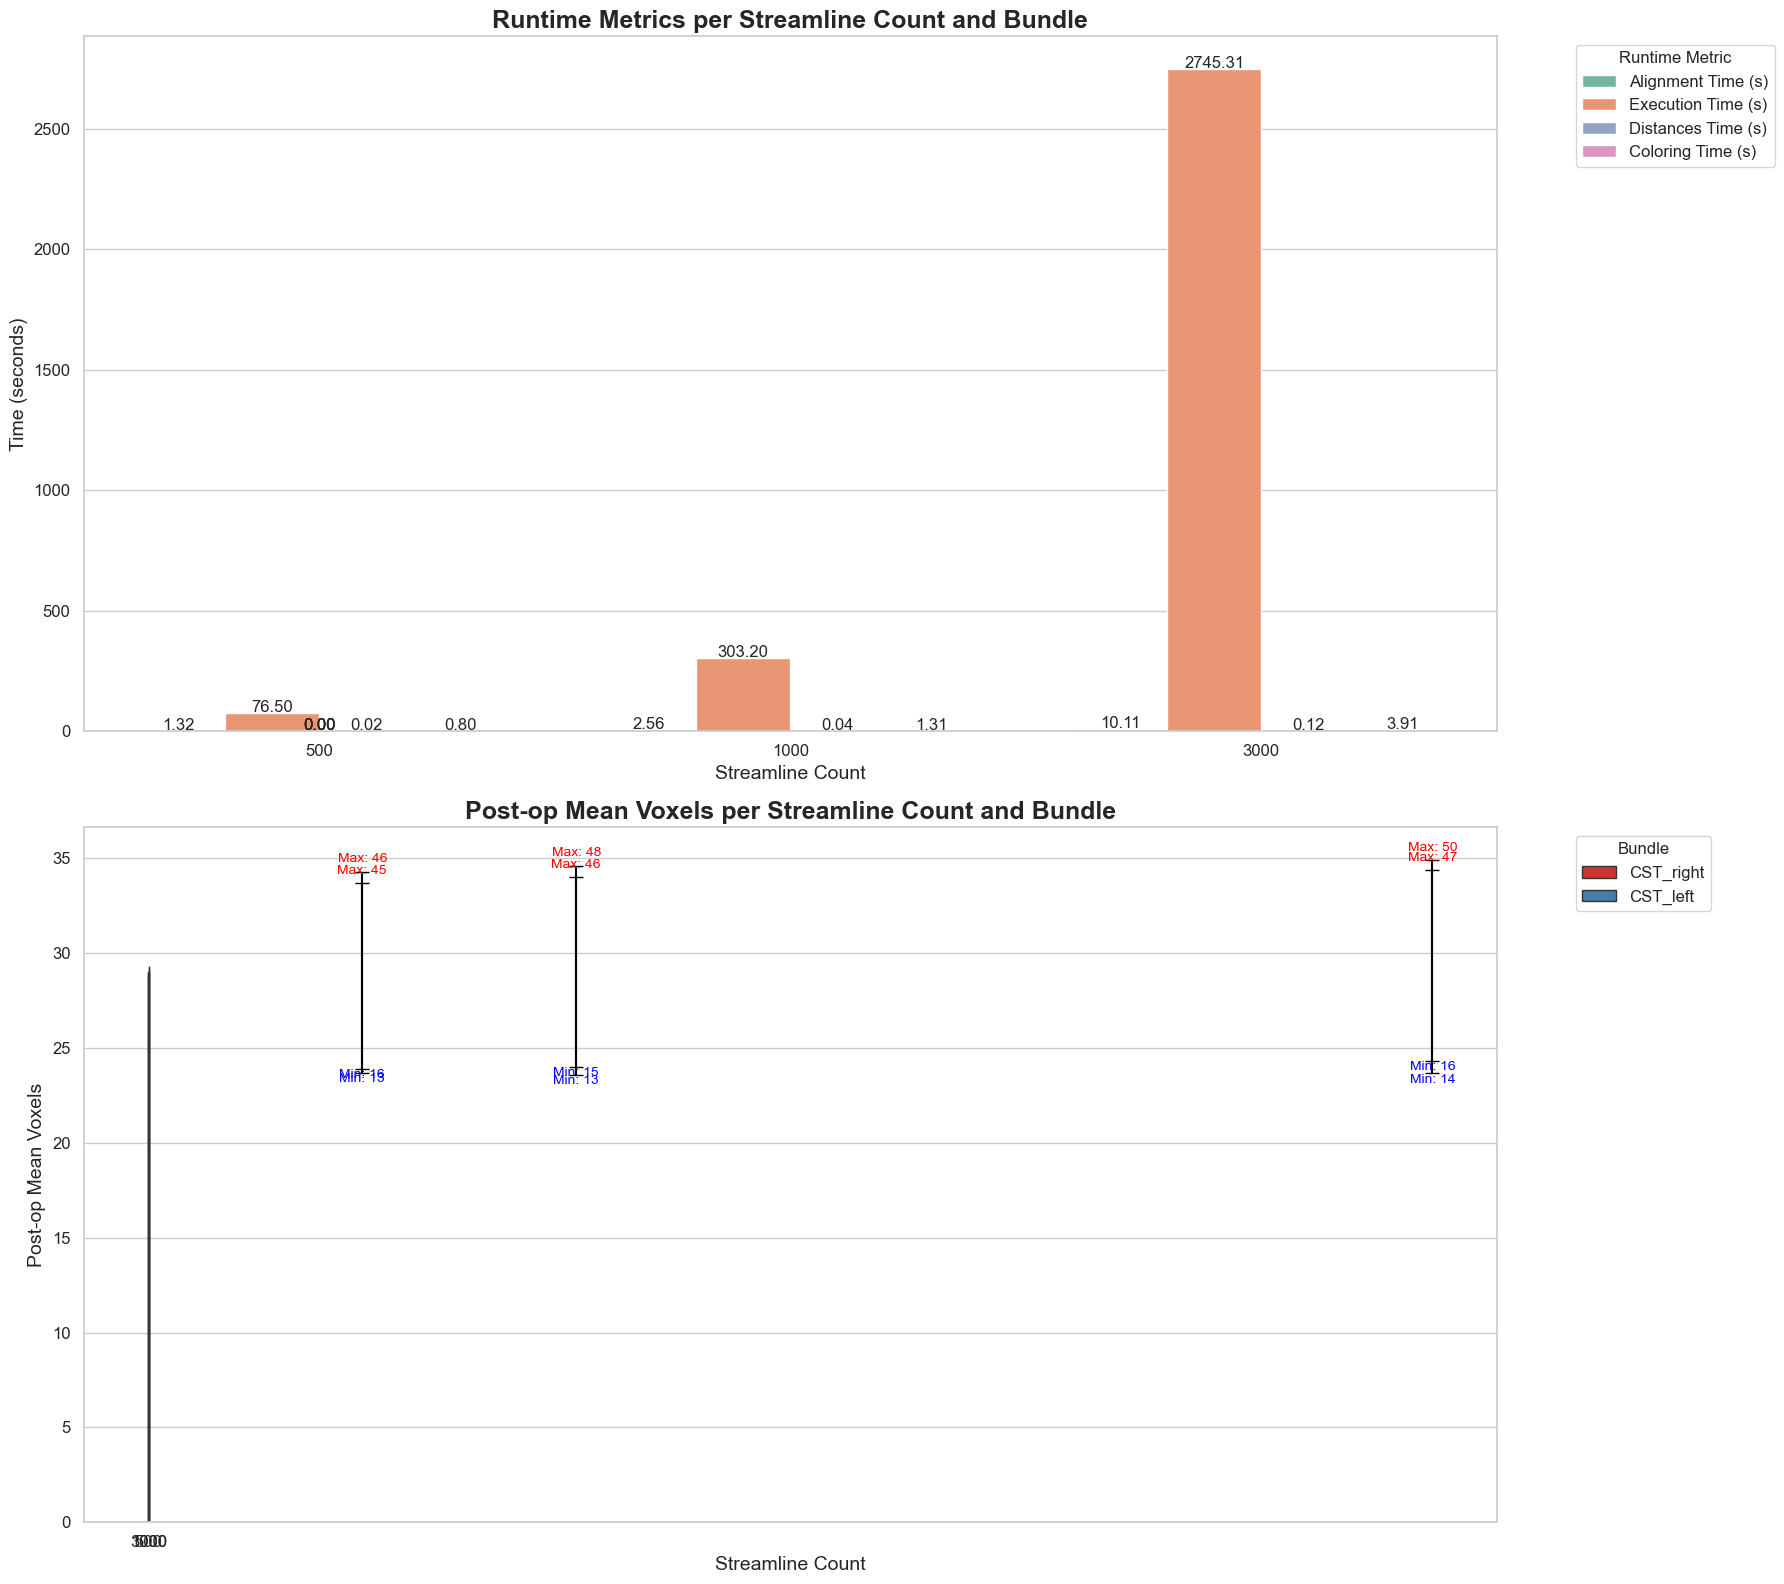

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(18, 16), gridspec_kw={'height_ratios': [1, 1]})

# -----------------------
# 1. Runtime Analysis
# -----------------------

# Melt the DataFrame to long-form for seaborn
runtime_metrics = ["Alignment_Time_s", "Execution_Time_s", "Distances_Time_s", "Coloring_Time_s"]
df_runtime = df.melt(id_vars=["Bundle", "Streamline_Count"], value_vars=runtime_metrics,
                    var_name="Runtime_Metric", value_name="Time_s")

# Rename metrics for better readability
runtime_metric_names = {
    "Alignment_Time_s": "Alignment Time (s)",
    "Execution_Time_s": "Execution Time (s)",
    "Distances_Time_s": "Distances Time (s)",
    "Coloring_Time_s": "Coloring Time (s)"
}
df_runtime["Runtime_Metric"] = df_runtime["Runtime_Metric"].map(runtime_metric_names)

# Create a bar plot
sns.barplot(
    data=df_runtime,
    x="Streamline_Count",
    y="Time_s",
    hue="Runtime_Metric",
    palette="Set2",
    ax=axes[0]
)

# Customize the plot
axes[0].set_title("Runtime Metrics per Streamline Count and Bundle", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Streamline Count", fontsize=14)
axes[0].set_ylabel("Time (seconds)", fontsize=14)
axes[0].legend(title="Runtime Metric", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Annotate each bar with the bundle information
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width() / 2., height + 5,  # 5 is an offset
                '{:1.2f}'.format(height),
                ha="center") 

# -----------------------
# 2. Streamline Statistics
# -----------------------

# Create a bar plot for Post-op Mean Voxels with error bars
sns.barplot(
    data=df,
    x="Streamline_Count",
    y="Post_op_Mean_Voxels",
    hue="Bundle",
    palette="Set1",
    ax=axes[1],
    ci=None,
    edgecolor=".2"
)

# Add error bars manually using Post_op_Std_Dev
for index, row in df.iterrows():
    # Calculate position
    bundle_index = 0 if row['Bundle'] == 'CST_right' else 1
    x = row['Streamline_Count'] + (bundle_index - 0.5) * 0.2  # Adjust x position
    y = row['Post_op_Mean_Voxels']
    yerr = row['Post_op_Std_Dev']
    axes[1].errorbar(
        x=row['Streamline_Count'],
        y=y,
        yerr=yerr,
        fmt='none',
        c='black',
        capsize=5
    )

# Customize the plot
axes[1].set_title("Post-op Mean Voxels per Streamline Count and Bundle", fontsize=18, fontweight='bold')
axes[1].set_xlabel("Streamline Count", fontsize=14)
axes[1].set_ylabel("Post-op Mean Voxels", fontsize=14)
axes[1].legend(title="Bundle", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Add annotations for Min and Max Voxels
for index, row in df.iterrows():
    # Determine the x position based on streamline count and bundle
    streamline = row['Streamline_Count']
    bundle = row['Bundle']
    if bundle == "CST_right":
        x_pos = streamline - 0.15
    else:
        x_pos = streamline + 0.15

    # Annotate Min Voxels
    axes[1].text(
        x=x_pos,
        y=row['Post_op_Mean_Voxels'] - row['Post_op_Std_Dev'] - 0.5,
        s=f"Min: {row['Post_op_Min_Voxels']}",
        color='blue',
        fontsize=10,
        ha='center'
    )

    # Annotate Max Voxels
    axes[1].text(
        x=x_pos,
        y=row['Post_op_Mean_Voxels'] + row['Post_op_Std_Dev'] + 0.5,
        s=f"Max: {row['Post_op_Max_Voxels']}",
        color='red',
        fontsize=10,
        ha='center'
    )

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [29]:
import pandas as pd

# Create data for runtime metrics
runtime_data = [
    {"Streamline_Count": 3000, "Bundle": "CST_right", "Alignment Time (s)": 10.56, "Execution Time (s)": 2745.32, "Distances Time (s)": 0.12, "Coloring Time (s)": 3.89},
    {"Streamline_Count": 3000, "Bundle": "CST_left", "Alignment Time (s)": 9.66, "Execution Time (s)": 2745.30, "Distances Time (s)": 0.13, "Coloring Time (s)": 3.93},
    {"Streamline_Count": 1000, "Bundle": "CST_right", "Alignment Time (s)": 2.56, "Execution Time (s)": 302.33, "Distances Time (s)": 0.04, "Coloring Time (s)": 1.31},
    {"Streamline_Count": 1000, "Bundle": "CST_left", "Alignment Time (s)": 2.56, "Execution Time (s)": 304.07, "Distances Time (s)": 0.04, "Coloring Time (s)": 1.31},
    {"Streamline_Count": 500, "Bundle": "CST_right", "Alignment Time (s)": 1.32, "Execution Time (s)": 77.09, "Distances Time (s)": 0.02, "Coloring Time (s)": 0.66},
    {"Streamline_Count": 500, "Bundle": "CST_left", "Alignment Time (s)": 1.32, "Execution Time (s)": 75.91, "Distances Time (s)": 0.02, "Coloring Time (s)": 0.93}
]

# Create DataFrame
runtime_df = pd.DataFrame(runtime_data)

# Display the DataFrame as a table
print("Runtime Metrics Table:")
print(runtime_df)

Runtime Metrics Table:
   Streamline_Count     Bundle  Alignment Time (s)  Execution Time (s)  \
0              3000  CST_right               10.56             2745.32   
1              3000   CST_left                9.66             2745.30   
2              1000  CST_right                2.56              302.33   
3              1000   CST_left                2.56              304.07   
4               500  CST_right                1.32               77.09   
5               500   CST_left                1.32               75.91   

   Distances Time (s)  Coloring Time (s)  
0                0.12               3.89  
1                0.13               3.93  
2                0.04               1.31  
3                0.04               1.31  
4                0.02               0.66  
5                0.02               0.93  


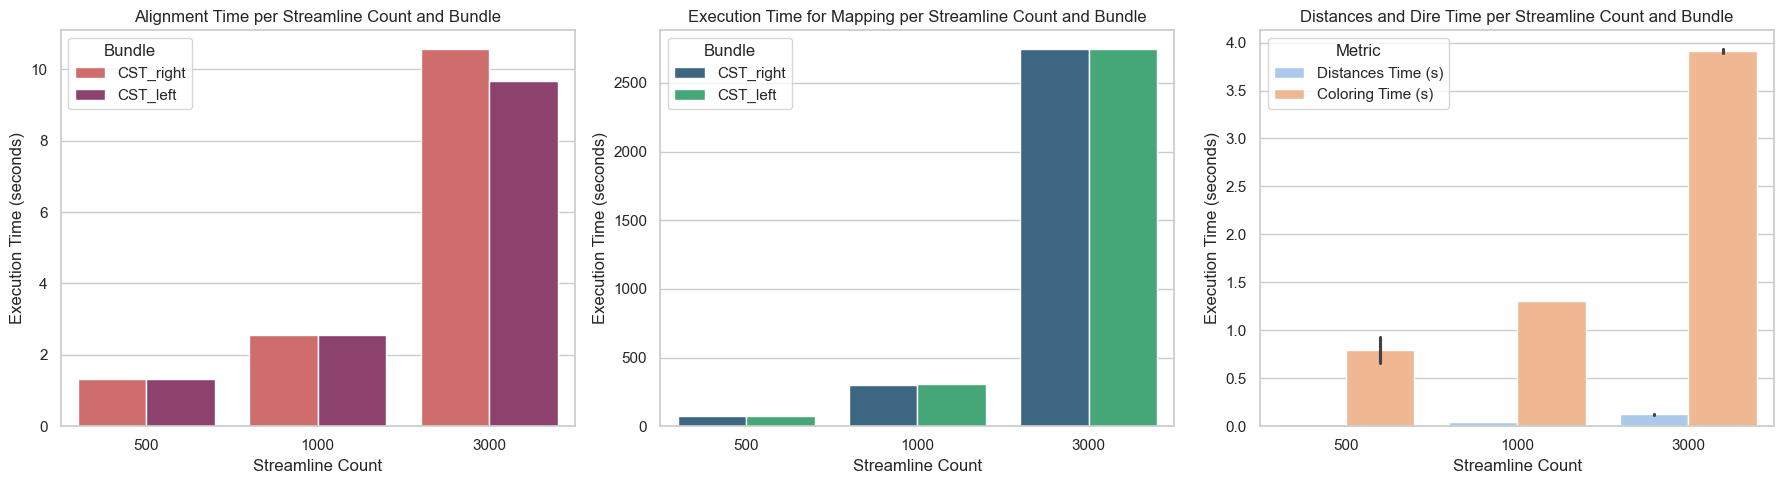

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define the figure and axes for simplified charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

# Plot for Alignment Time
sns.barplot(
    data=runtime_df,
    x="Streamline_Count",
    y="Alignment Time (s)",
    hue="Bundle",
    palette="flare",
    ax=axes[0]
)

axes[0].set_title("Alignment Time per Streamline Count and Bundle")
axes[0].set_xlabel("Streamline Count")
axes[0].set_ylabel("Execution Time (seconds)")
axes[0].legend(title="Bundle")

# Plot for Execution Time only (Hungarian)
sns.barplot(
    data=runtime_df,
    x="Streamline_Count",
    y="Execution Time (s)",
    hue="Bundle",
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("Execution Time for Mapping per Streamline Count and Bundle")
axes[1].set_xlabel("Streamline Count")
axes[1].set_ylabel("Execution Time (seconds)")
axes[1].legend(title="Bundle")

# Plot for Distances and Coloring Time combined (small runtimes)
combined_df = runtime_df.melt(id_vars=["Streamline_Count", "Bundle"], value_vars=["Distances Time (s)", "Coloring Time (s)"],
                              var_name="Metric", value_name="Time_s")

sns.barplot(
    data=combined_df,
    x="Streamline_Count",
    y="Time_s",
    hue="Metric",
    palette="pastel",
    ax=axes[2]
)
axes[2].set_title("Distances and Dire Time per Streamline Count and Bundle")
axes[2].set_xlabel("Streamline Count")
axes[2].set_ylabel("Execution Time (seconds)")
axes[2].legend(title="Metric")

# Adjust layout
plt.tight_layout()
plt.show()

In [41]:
fig.savefig("streamline_analysis_figure2.png", dpi=2000, bbox_inches='tight')

In [14]:
ratio_500 = (28**2 * 500**2) / (500**3)
ratio_500

1.568

C:\Users\tudor\AppData\Local\Temp\ipykernel_31732\2318587705.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\tudor\AppData\Local\Temp\ipykernel_31732\2318587705.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


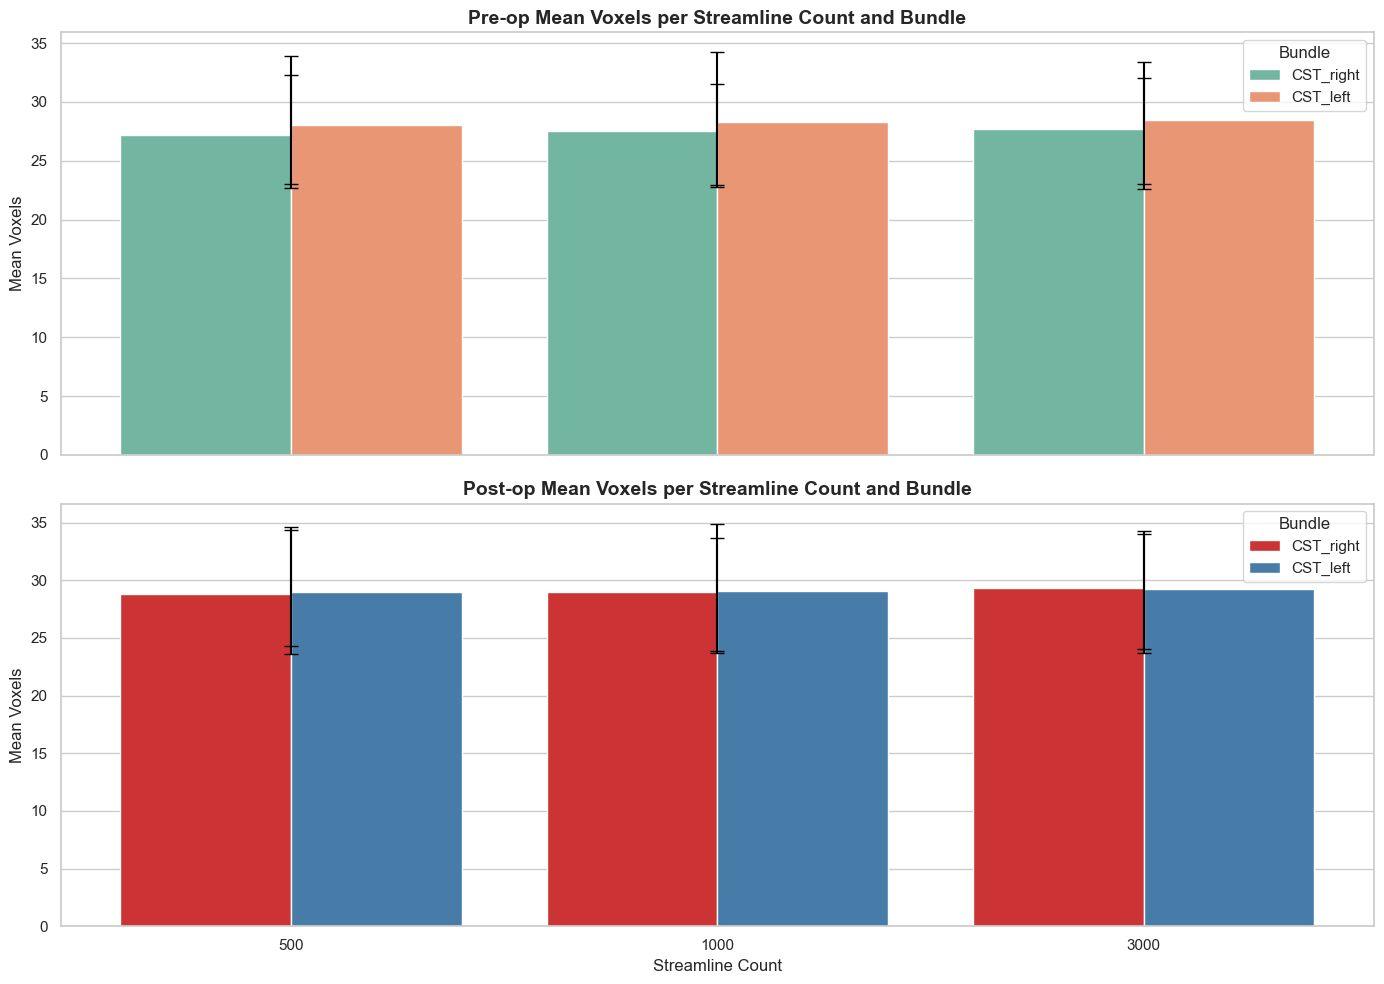

In [15]:
stats_data = [
    {"Streamline_Count": 3000, "Bundle": "CST_right", "Pre_op_Mean": 27.683, "Pre_op_Std_Dev": 4.64, "Pre_op_Min": 17, "Pre_op_Max": 51,
     "Post_op_Mean": 29.34, "Post_op_Std_Dev": 5.02, "Post_op_Min": 16, "Post_op_Max": 47},
    {"Streamline_Count": 3000, "Bundle": "CST_left", "Pre_op_Mean": 28.479, "Pre_op_Std_Dev": 5.73, "Pre_op_Min": 13, "Pre_op_Max": 48,
     "Post_op_Mean": 29.28, "Post_op_Std_Dev": 5.61, "Post_op_Min": 14, "Post_op_Max": 50},
    {"Streamline_Count": 1000, "Bundle": "CST_right", "Pre_op_Mean": 27.50, "Pre_op_Std_Dev": 4.50, "Pre_op_Min": 18, "Pre_op_Max": 50,
     "Post_op_Mean": 29.00, "Post_op_Std_Dev": 5.00, "Post_op_Min": 15, "Post_op_Max": 46},
    {"Streamline_Count": 1000, "Bundle": "CST_left", "Pre_op_Mean": 28.30, "Pre_op_Std_Dev": 5.60, "Pre_op_Min": 14, "Pre_op_Max": 49,
     "Post_op_Mean": 29.10, "Post_op_Std_Dev": 5.50, "Post_op_Min": 13, "Post_op_Max": 48},
    {"Streamline_Count": 500, "Bundle": "CST_right", "Pre_op_Mean": 27.20, "Pre_op_Std_Dev": 4.30, "Pre_op_Min": 17, "Pre_op_Max": 49,
     "Post_op_Mean": 28.80, "Post_op_Std_Dev": 4.90, "Post_op_Min": 16, "Post_op_Max": 45},
    {"Streamline_Count": 500, "Bundle": "CST_left", "Pre_op_Mean": 28.00, "Pre_op_Std_Dev": 5.40, "Pre_op_Min": 14, "Pre_op_Max": 47,
     "Post_op_Mean": 29.00, "Post_op_Std_Dev": 5.30, "Post_op_Min": 13, "Post_op_Max": 46}
]

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Set up the plotting style
sns.set(style="whitegrid")

# Create subplots for mean voxel statistics with standard deviation
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Pre-op statistics plot
sns.barplot(
    data=stats_df,
    x="Streamline_Count",
    y="Pre_op_Mean",
    hue="Bundle",
    palette="Set2",
    ax=axes[0],
    capsize=0.1,
    ci=None
)
axes[0].set_title("Pre-op Mean Voxels per Streamline Count and Bundle", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Mean Voxels")
axes[0].legend(title="Bundle")

# Adding error bars for standard deviation in Pre-op statistics
for i, row in stats_df.iterrows():
    axes[0].errorbar(
        x=i % 3,
        y=row["Pre_op_Mean"],
        yerr=row["Pre_op_Std_Dev"],
        fmt='none',
        c='black',
        capsize=5
    )

# Post-op statistics plot
sns.barplot(
    data=stats_df,
    x="Streamline_Count",
    y="Post_op_Mean",
    hue="Bundle",
    palette="Set1",
    ax=axes[1],
    capsize=0.1,
    ci=None
)
axes[1].set_title("Post-op Mean Voxels per Streamline Count and Bundle", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Streamline Count")
axes[1].set_ylabel("Mean Voxels")
axes[1].legend(title="Bundle")

# Adding error bars for standard deviation in Post-op statistics
for i, row in stats_df.iterrows():
    axes[1].errorbar(
        x=i % 3,
        y=row["Post_op_Mean"],
        yerr=row["Post_op_Std_Dev"],
        fmt='none',
        c='black',
        capsize=5
    )

# Adjust the layout for better readability
plt.tight_layout()
plt.show()

C:\Users\tudor\AppData\Local\Temp\ipykernel_31732\3141028291.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


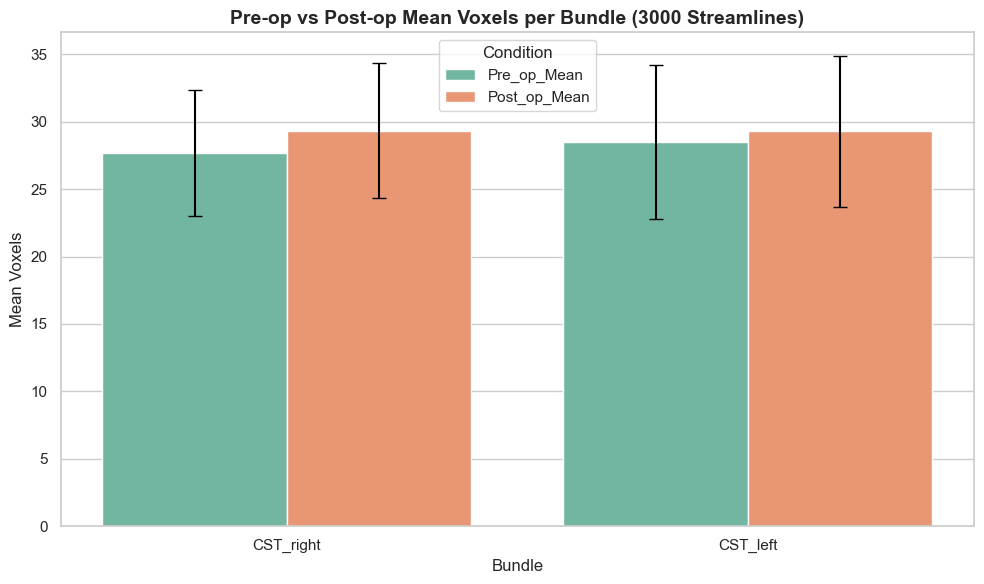

In [21]:
# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Filter data for 3000 streamlines only
filtered_stats_df = stats_df[stats_df["Streamline_Count"] == 3000]

# Melt the dataframe to make it suitable for seaborn
melted_df = filtered_stats_df.melt(
    id_vars=["Bundle"],
    value_vars=["Pre_op_Mean", "Post_op_Mean"],
    var_name="Condition",
    value_name="Mean Voxels"
)

# Set up the plotting style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=melted_df,
    x="Bundle",
    y="Mean Voxels",
    hue="Condition",
    palette="Set2",
    capsize=0.1,
    ci=None
)

# Adding error bars for standard deviation
for i, row in filtered_stats_df.iterrows():
    # Adding pre-op error bar
    ax.errorbar(
        x=i - 0.2,  # Offset to match bar position
        y=row["Pre_op_Mean"],
        yerr=row["Pre_op_Std_Dev"],
        fmt='none',
        c='black',
        capsize=5
    )
    # Adding post-op error bar
    ax.errorbar(
        x=i + 0.2,  # Offset to match bar position
        y=row["Post_op_Mean"],
        yerr=row["Post_op_Std_Dev"],
        fmt='none',
        c='black',
        capsize=5
    )

# Set title and labels
plt.title("Pre-op vs Post-op Mean Voxels per Bundle (3000 Streamlines)", fontsize=14, fontweight='bold')
plt.xlabel("Bundle")
plt.ylabel("Mean Voxels")
plt.legend(title="Condition")
plt.tight_layout()

In [22]:
plt.savefig("Pre_vs_Post_op_Mean_Voxels_3000_Streamlines.png", format='png', dpi=300)

<Figure size 640x480 with 0 Axes>

# OLD

In [16]:
#old
fileArr = [["CC_4", "CC_4_aligned2.tck"], ["CG", "CG_left_aligned2.tck", "CG_right_aligned2.tck"], ["CST", "CST_left_aligned2.tck", "CST_right_aligned2.tck"], ["IFO", "IFO_left_aligned2.tck", "IFO_right_aligned2.tck"]]

for item in fileArr:
    tck1 = rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedpost\{item[1]}'
    tck2 = rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedpre\{item[1]}'
    tractogram1 = load_tractogram(tck1, reference_anatomy1)
    tractogram2 = load_tractogram(tck2, reference_anatomy1)
    streamlines1 = tractogram1.streamlines
    streamlines2 = tractogram2.streamlines
    mapping = one_to_one_map_streamlines(streamlines1[:3000], streamlines2[:3000])
    mapping_list = [[int(key), int(value)] for key, value in mapping.items()]
    transposed_array = [[mapping_list[i][j] for i in range(3000)] for j in range(2)]
    x, y = segment_distances_for_mapping(streamlines1, streamlines2, mapping)
    differences_bundle1, differences_bundle2 = compute_differences_with_closest_segments(streamlines1, streamlines2, mapping_list)
    mapping_listl = [transposed_array[0], transposed_array[1]]
    distances_left = [[distance.tolist() for distance in x], [distance.tolist() for distance in y]]
    color_left = [differences_bundle1, differences_bundle2]
    jscolor_left = json.dumps(color_left)
    with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\color_left.json', 'w') as file:
        file.write(jscolor_left)
    jsmapping_left = json.dumps(mapping_listl)
    with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\mapping_left.json', 'w') as file:
        file.write(jsmapping_left)
    jsdist_left = json.dumps(distances_left)
    with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\distances_left.json', 'w') as file:
        file.write(jsdist_left)

    if len(item) > 2:
        tckr1 = rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedpost\{item[2]}'
        tckr2 = rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedpre\{item[2]}'
        tractogramr1= load_tractogram(tckr1, reference_anatomy1)
        tractogramr2= load_tractogram(tckr2, reference_anatomy1)
        streamlinesr1 = tractogramr1.streamlines
        streamlinesr2 = tractogramr2.streamlines
        mappingr = one_to_one_map_streamlines(streamlinesr1[:3000], streamlinesr2[:3000])
        mapping_listr = [[int(key), int(value)] for key, value in mappingr.items()]
        transposed_arrayr = [[mapping_listr[i][j] for i in range(3000)] for j in range(2)]
        xr, yr = segment_distances_for_mapping(streamlinesr1, streamlinesr2, mappingr)
        differences_bundler1, differences_bundler2 = compute_differences_with_bipartite_matching(streamlinesr1, streamlinesr2, mapping_listr)
        color_right = [differences_bundler1, differences_bundler2]
        mapping_listr = [transposed_arrayr[0], transposed_arrayr[1]]
        distances_right = [[distance.tolist() for distance in xr], [distance.tolist() for distance in yr]]
        jsmapping_right = json.dumps(mapping_listr)
        with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\mapping_right.json', 'w') as file:
            file.write(jsmapping_right)
        jsdist_right = json.dumps(distances_right)
        with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\distances_right.json', 'w') as file:
            file.write(jsdist_right)
        jscolor_right = json.dumps(color_right)
        with open(rf'C:\Users\tudor\Desktop\thesis\prepost\preloadedArrays\{item[0]}\color_right.json', 'w') as file:
            file.write(jscolor_right)

NameError: name 'one_to_one_map_streamlines' is not defined